# **Afternoon practical day 1** <br>
Welcome to the afternoon practical. Here, you're going to write a function to use cross-validation rather than training on all data. After that, you'll implement multivariate linear regression with linear algebra using numpy. Finally, you'll run it on a small dataset of SNPs, thereby performing an elementary GWAS analysis.

In [1]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
import scipy
import random as rand
%matplotlib notebook
import crossValFunction

In [2]:
#necessary functions you defined before:
def univariateHypothesis(x, thetas):
    predict = thetas[0] + thetas[1] * x
    return predict

def multiHypothesis(x, thetas, printit = False):
    #add a 1 to x as the first 'feature'
    one_to_add = np.array([1])
    if printit:
        print(x)
        print(one_to_add)
        print(x.shape)
        print(one_to_add.shape)
    x = np.concatenate((one_to_add, x))
    if printit: print(x)
    if not len(x) == len(thetas):
        print("Error, x and theta should have equal length!")
        return
    prediction = sum([curr_x * curr_theta for curr_x, curr_theta in zip(x, thetas)])
    #faster way
    if printit:
        print(x) 
        print(thetas)
    prediction = np.sum(x*thetas)
    return prediction

def MyMSE(x, y, thetas):
    totalSumSquares = 0
    for index, val in enumerate(x):
        prediction = multiHypothesis(val, thetas)
        squareError = (prediction-y[index])**2
        totalSumSquares += squareError
    meanSquaredError = totalSumSquares/len(x) 
    return meanSquaredError

def gradientDescent(x, y, thetas, alpha):
    m = len(x)
    total_error_thetas = np.zeros_like(thetas)
    for index, row in enumerate(x):
        hypothesis_outcome = multiHypothesis(row, thetas)
        row_with_one = np.concatenate((np.array([1]), row))
        errors_this_sample = (hypothesis_outcome - y[index]) * row_with_one
        total_error_thetas = total_error_thetas + errors_this_sample
    final_thetas = thetas - alpha/m * total_error_thetas
    return final_thetas

def makePolynomialFeatures(x, power = 2, printit = False):
    data = []
    for i in range (1, power+1):
        data.append(x**i)
    if printit: print(data)
    finalArray = np.vstack(tuple(data)).T
    if printit: print(finalArray)
    return finalArray

def createNormalisedFeatures(featureArray, mode = "range", printit = False):
    if printit: print(featureArray)
    featureMeans = np.mean(featureArray, axis = 0, keepdims=True)
    if printit: print(featureMeans)
    if printit: print(featureArray-featureMeans)
    if mode == "range":
        featureRanges = np.max(featureArray, axis = 0, keepdims=True) - np.min(featureArray, axis = 0, keepdims=True)
        #broadcasting in action:
        normalisedFeatures = (featureArray - featureMeans)/featureRanges
        return [normalisedFeatures, featureMeans, featureRanges]
    elif mode == "SD":
        featureSDs = np.std(featureArray, axis = 0, keepdims=True)
        #broadcasting in action:
        normalisedFeatures = (featureArray - featureMeans)/featureSDs
        return [normalisedFeatures, featureMeans, featureSDs]


#sample data for use
data = np.loadtxt("sampleDataLinearRegression.csv", delimiter=',')
x_data, y_data = data[:,0], data[:,1]

featuresHP = makePolynomialFeatures(x_data, power = 2)

normalisedFeaturesHP, featureMeansHP, featureRangesHP = createNormalisedFeatures(featuresHP, mode = "range")

# Using cross-validation
So far, we've only been fitting on all the data. That's not great for knowing about how we will generalise, as we have discussed, and we don't know whether we might be overfitting. Here, I show you an example of a cross-validated linear regression. I have supplied a function that does cross-validation (cv), and show you the outcome for a 9-fold cross-validation on the sample linear regression data we have been using all along. At the end of the practical, writing your own cross-validation function (i.e. a function that splits data into k folds and returns those) is an _optional_ extra thing to do. Ten folds are often used (10-fold cross-validation), although that's not because it is universally optimal. See here: https://stats.stackexchange.com/a/357749 and here: https://stats.stackexchange.com/a/264721 for more info. It comes down to the bias-variance trade-off that you have heard about. And maybe to the monkey see monkey do-mindset that is rather more pervasive in science than one might like to admit. That is: everybody uses 10-fold cross-validation so we do it too (to be comparable). <br> For now, let's set that discussion aside, and focus on how cross-validation looks for the case where we fit a quadratic equation to linear data (for some arcane reason). You can scan through the code below, but the gist of it is: it splits the data into 9 folds, fits a linear regression (with two features, one quadratic) on training data, then applies it to the test data, and plots how that looks, along with the MSE.

List of training set indices to use: 

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20, 12, 13, 18, 14, 15, 19, 16, 17], [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 20, 12, 13, 18, 14, 15, 19, 16, 17], [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 20, 12, 13, 18, 14, 15, 19, 16, 17], [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 20, 12, 13, 18, 14, 15, 19, 16, 17], [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 20, 12, 13, 18, 14, 15, 19, 16, 17], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 18, 14, 15, 19, 16, 17], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20, 14, 15, 19, 16, 17], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20, 12, 13, 18, 16, 17], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20, 12, 13, 18, 14, 15, 19]]
--------
List of test set indices to use: 

[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11, 20], [12, 13, 18], [14, 15, 19], [16, 17]]
Average test set error: 0.02


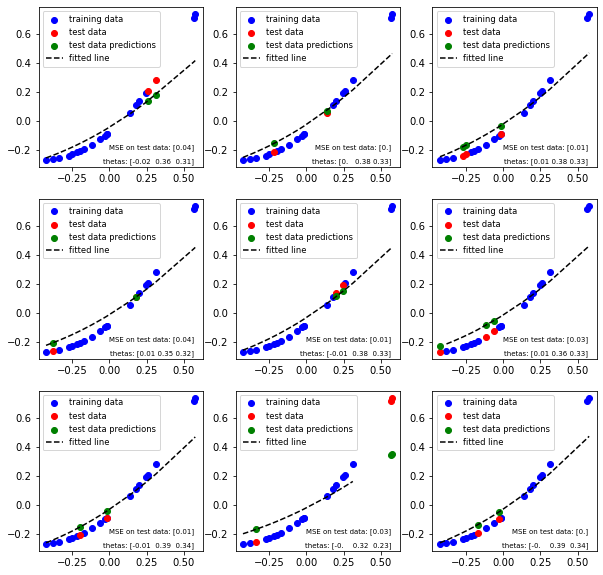

In [31]:
#Run your function
%matplotlib inline
normalised_y_data, _, _ = createNormalisedFeatures(y_data[:,np.newaxis])
shuffledFeatureArray, shuffledLabels, trainSetIndices, testSetIndices = crossValFunction.makeCrossValData(normalisedFeaturesHP, normalised_y_data, 9)

print("List of training set indices to use: \n")
print(trainSetIndices)
print("--------")
print("List of test set indices to use: \n")
print(testSetIndices)

#make a figure to show this
stepsGradDescent = 40
#note: this alpha actually results in rising MSE values after a number of gradient descent steps. In a real scenario,
#I would recommend an alpha of 0.01 to start
alpha = 0.2 
startThetas = [0,0,0]

#lists to store information for all cross-validations:
thetaValuesDuringDescent = []
MSEDuringDescent = []
testMSE = []

figCrossVal, axsCrossVal = plt.subplots(nrows = 3, ncols = 3, figsize = (10,10))


for i in range (0,9):
    trainSubset = shuffledFeatureArray[trainSetIndices[i],:]
    trainSubsetLabels = shuffledLabels[trainSetIndices[i]]
    testSubset  = shuffledFeatureArray[testSetIndices[i],:]
    testSubsetLabels = shuffledLabels[testSetIndices[i]]
    thetaValuesDuringDescent.append([])
    MSEDuringDescent.append([])
    thetasNow = startThetas.copy()
    
    for steps in range(0,stepsGradDescent):
        oneStep = gradientDescent(trainSubset, trainSubsetLabels, thetasNow, alpha)
        thetaValuesDuringDescent[-1].append(oneStep)
        thetasNow = oneStep
        MSEDuringDescent[-1].append(MyMSE(trainSubset, trainSubsetLabels, thetasNow))
    
    #with final thetas, test on the validation set and check MSE
    testMSE.append(MyMSE(testSubset, testSubsetLabels, thetasNow))
    

#now plot this data
counterPlotting = 0
for plotY in range(0,3):
    for plotX in range(0,3):

        #print(counterPlotting)
        axsCrossVal[plotX, plotY].scatter(shuffledFeatureArray[trainSetIndices[counterPlotting],0],
                           shuffledFeatureArray[trainSetIndices[counterPlotting],-1],
                           color = "blue", label = "training data")
        axsCrossVal[plotX, plotY].scatter(shuffledFeatureArray[testSetIndices[counterPlotting],0],
                           shuffledFeatureArray[testSetIndices[counterPlotting],-1],
                           color = "red", label = "test data")
        #plot predicted test data
        axsCrossVal[plotX, plotY].scatter(shuffledFeatureArray[testSetIndices[counterPlotting],0],
                           [multiHypothesis(x_vals, thetaValuesDuringDescent[counterPlotting][-1]) for x_vals, y_vals in zip(shuffledFeatureArray[testSetIndices[counterPlotting],:], shuffledLabels[testSetIndices[counterPlotting]])],
                           color = "green", label = "test data predictions")
        
        #plot all data as predicted by these thetas
        xValuesToPlotHere      = shuffledFeatureArray[trainSetIndices[counterPlotting],0]
        fittedValuesToPlotHere = [multiHypothesis(x_vals, thetaValuesDuringDescent[counterPlotting][-1]) for x_vals, y_vals in zip(shuffledFeatureArray[trainSetIndices[counterPlotting],:], shuffledLabels[trainSetIndices[counterPlotting]])]
        zippedTogether         = list(zip(xValuesToPlotHere, fittedValuesToPlotHere))
        sortedZipped           = sorted(zippedTogether, key = lambda x : x[0])
        unzippedXAndFitted     = list(zip(*sortedZipped))
        xValuesToPlotHere      = unzippedXAndFitted[0]
        fittedValuesToPlotHere = unzippedXAndFitted[1]
        axsCrossVal[plotX, plotY].plot(xValuesToPlotHere, fittedValuesToPlotHere,
                    color = "black", label = "fitted line", linestyle = 'dashed')
        
        axsCrossVal[plotX, plotY].legend(fontsize = "small")
        
        #add theta values for this cross-validation
        stringToAdd = 'thetas: ' + str(np.round(thetaValuesDuringDescent[counterPlotting][-1], 2))
        axsCrossVal[plotX, plotY].text(0.95, 0.01, stringToAdd ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axsCrossVal[plotX, plotY].transAxes,
        color='black', fontsize=7)
        
        #add mean-squared error on the test set
        stringToAdd = 'MSE on test data: ' + str(np.round(testMSE[counterPlotting], 2))
        axsCrossVal[plotX, plotY].text(0.95, 0.10, stringToAdd ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axsCrossVal[plotX, plotY].transAxes,
        color='black', fontsize=7)
        counterPlotting += 1
        
        
print("Average test set error: " + str(np.round(np.mean(testMSE), 2)))

# Cross-validated polynomial fitting outcome and real-life complications for cross-validation

Unsurprisingly, you'll see that the prediction performance is abysmal, and also varies a lot per cross-validation. This is because the polynomial function actually doesn't fit the data as it is linear, and there is extremely little data. Hence, it matters a lot which data points are in the test set and which aren't. The scale makes the MSE seem small, but you'll agree that the fit is not good. <br>
Still, it's a good illustration of the power of cross-validation: by seperating our data and training on subsets, we can get a better idea of the generalisation performance, i.e. how well our model will perform on real-world data. If we'd have had a good model rather than a toy one, we could now decide to train the final model on **all** training data, and then publish it and put it to use. <br>

There is a catch: cross-validation in k folds assumes that the data we will be predicting on in the real world will be very much _like_ the data we are training the model on. The assumption is called IID, that data is Independent and Identically Distributed. This is often simply not true. The ML field is having a reckoning with this. See for example [this](https://arxiv.org/abs/2210.07242) or [this](https://openaccess.thecvf.com/content/ICCV2021/html/Hendrycks_The_Many_Faces_of_Robustness_A_Critical_Analysis_of_Out-of-Distribution_ICCV_2021_paper.html), or [here, under A. OBSTACLES TO ACHIEVING SAFETY, ROBUSTNESS, AND RELIABILITY](https://ieeexplore.ieee.org/abstract/document/9783196). As an example superhuman classifiers trained on ImageNet fail completely when you show them images from China, because, say, kitchens in China can look vastly different from what has been learned as a kitchen in datasets biased towards European or American images. That might seem an easy solve: just include images from everywhere. Do note: covering every possibility is hard if not impossible. 

However, consider a hospital setting: you train a classifier on 200 patients' gene expression data to predict whether or not they should have resection of part of their large intestine when they get cancer. This works great, you validate, everything is fine. But shift starts to occur: maybe the gene expression profiling platform changes, the hospital gets a new machine, clinical procedures change, some upstream decision means that the patient population that is screened with your classifier changes, etc. We call this _dataset shift_. It is basically inevitable that you will ask your classifier to work on samples that differ in subtle and not-so-subtle ways from what was seen during training, and that is dangerous. For this reason, more realistic cross-validation procedures are designed, that give a view on generalisation potential under data shift. If you are predicting protein-protein interactions, train on the database containing data up to and until 2018, and then predict on the new data up to 2022. If you are training on gene expression data, leave all expression from a specific study or specific countries or medical centres out, and see how well you generalise on those. There's also ways to monitor whether a sample is very different from all others, but this is a very active field of study.


# Linear algebra exercises

Until now, you've been working with for loops and lists, looping over the theta values and corresponding features, multiplying them, then summing these and thereby obtaining the final predictions. For gradient descent, too, we have been working with iteration. As you've been told in the lectures, the language of machine learning is linear algebra. We're now going to focus on implementing what you've done so far in linear algebra. Before we move on, if you're still a little bit unsure about some of what we've done until now, please watch some of the videos given in the course reader, for example on linear regression, the bias-variance trade-off, or cross-validation.

Let's get a bit of a feel for working with matrices. To do that, we'll do some pen-and-paper exercises:
* Go [here](https://www.algebrapracticeproblems.com/matrix-multiplication-product-multiplying-matrices/), read the text and do the first 3 practice problems. You can check your solutions on the site. Be sure to read through the procedures and properties of matrix multiplication so you're sure about your understanding.
* After that's done, do the 3 problems below: <br> <br> <br>

1. $\begin{bmatrix} 6 & -2 & 5 \\ 1 & 6 & 2 \\ -3 & 4 & 7 \end{bmatrix} \cdot \begin{bmatrix} -4 \\ 8 \\ 3 \end{bmatrix}$ <br> <br>
2. $\begin{bmatrix} 2 & -6 & 11 \end{bmatrix} \cdot \begin{bmatrix} -16 \\ -5 \\ 2 \end{bmatrix}$ <br> <br>
3. $\begin{bmatrix} 2 & -6 & 11 \end{bmatrix} \cdot \begin{bmatrix} 2 \\ -6 \\ 11 \end{bmatrix}$

<br> <br> <br> <br> 


Note that problem 3 is the same as summing the element-wise squares of the vector entries. In other words: squaring vector elements and summing them is equal to $V^t*V$

# Checking your answers with numpy

Instead of supplying answers for the above, how's about you check it yourself using numpy? Use the following commands:

* `np.array([[6, 12, 3], [4, 5, 6]])` will result in $\begin{bmatrix} 6 & 12 & 3 \\ 4 & 5 & 6 \end{bmatrix}$
* `A = np.array([[6, 12, 3], [4, 5, 6]])` <br>`B = np.array([[3, 4], [-2, 8], [8, 9]])` <br> `A @ B` <br> 
will result in $\begin{bmatrix} 6 & 12 & 3 \\ 4 & 5 & 6 \end{bmatrix} \cdot \begin{bmatrix} 3 & 4 \\ -2 & 8 \\ 8 & 9 \end{bmatrix} = \begin{bmatrix} 18 & 147 \\ 50 & 110 \end{bmatrix}$ <br>
* `A.transpose()` or `A.T` will yield $\begin{bmatrix} 6 & 4 \\ 12 & 5 \\ 3 & 6 \end{bmatrix}$ (useful for the 3rd problem so you don't repeat yourself)

Check your answers for the three final questions above using these commands in the code cell below.



In [5]:
#answers
#1. 
A = np.array([[6, -2, 5], [1, 6, 2], [-3, 4, 7]])
B = np.array([[-4], [8], [3]])
ans1 = A@B
print(f'Answer 1 : \n {ans1} \n')

#2.
C = np.array([2, -6, 11])
D = np.array([-16, -5, 2])
ans2 = C@D
print(f'Answer 2 : \n {ans2} \n')

#3
ans3 = C.T @ C
print(f'Answer 3 : \n {ans3} \n')

Answer 1 : 
 [[-25]
 [ 50]
 [ 65]] 

Answer 2 : 
 20 

Answer 3 : 
 161 



# Rewriting the univariate and multivariate regression function with linear algebra

In the code cell below, you've been given working examples of the regression hypothesis functions you've been working with. Your job is to make just one function `linAlgRegHypothesis(data, thetas)` that can perform linear regression for any number of features, using linear algebra . To do this, remember the following:
* You can just prepend 1 to a feature vector to make the multiplication of a theta-vector with those features incredibly straightforward.
* You don't need to loop: you can just calculate all predicted values at once using matrix-vector multiplication.
* Use `np.array(normalisedFeaturesHP.loc[:, ["xtoPower1", "xtoPower2"]])` for testing. You'll probably have to use the transpose function.
* To add a column of ones to a feature matrix, use `np.c_[arrayOfOnes, featureArrayOrMatrix]` They should of course have the same length (number of rows).

If you have trouble grappling with numpy, read [this](https://numpy.org/doc/stable/user/absolute_beginners.html) and use [the numpy documentation](https://numpy.org/doc/stable/reference/index.html).

In [6]:
def univariateHypothesis(x, thetas):
    predict = thetas[0] + thetas[1] * x
    return predict

def multiHypothesis(x, thetas, printit = False):
    #add a 1 to x as the first 'feature'
    one_to_add = np.array([1])
    if printit:
        print(x)
        print(one_to_add)
    x = np.concatenate((one_to_add, x))
    if not len(x) == len(thetas):
        print("Error, x and theta should have equal length!")
        return
    prediction = sum([curr_x * curr_theta for curr_x, curr_theta in zip(x, thetas)])
    #faster way
    prediction = np.sum(x*thetas)
    return prediction


#answer
def linAlgRegHypothesis(data, thetas):
    #print(thetas)
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    oneFeatToAdd = np.ones(len(data))
    newFeatArray = np.c_[oneFeatToAdd, data]
    predictions = newFeatArray @ thetas
    return predictions

Let's compare the two functions for a given theta vector

In [9]:
#in case something got overwritten
data = np.loadtxt("sampleDataLinearRegression.csv", delimiter=',')
x_data, y_data = data[:,0], data[:,1]
featuresHP = makePolynomialFeatures(x_data, power = 2)
normalisedFeaturesHP, featureMeansHP, featureRangesHP = createNormalisedFeatures(featuresHP, mode = "range")

thetas        = np.array([12, 3, 5])
#data          = np.array(normalisedFeaturesHP.loc[:, ["xtoPower1", "xtoPower2"]])
oldFuncOutput = np.array([multiHypothesis(row, thetas) for row in normalisedFeaturesHP])
newFuncOutput = linAlgRegHypothesis(normalisedFeaturesHP, thetas)

print("Old output: \n")
print(str(oldFuncOutput) + "\n")
print("New output: \n")
print(str(newFuncOutput))

print(np.all(oldFuncOutput==newFuncOutput))

Old output: 

[ 9.39761492  9.54799086  9.7168746  10.00490237 10.11016552 10.2767358
 10.39356633 10.51502382 10.83891046 11.19171555 11.41727946 11.49478091
 11.49478091 12.70125864 13.08760913 13.28772481 13.70183701 13.80825691
 14.35770746 17.25764962 17.39761492]

New output: 

[ 9.39761492  9.54799086  9.7168746  10.00490237 10.11016552 10.2767358
 10.39356633 10.51502382 10.83891046 11.19171555 11.41727946 11.49478091
 11.49478091 12.70125864 13.08760913 13.28772481 13.70183701 13.80825691
 14.35770746 17.25764962 17.39761492]
True


# Making a mean-squared error function and gradient descent with linear algebra

Now that you've performed this feat for the hypothesis function, let's do the same for the myMSE function and gradient descent. Start with the Mean-Squared error function. 

So:

* Rewrite the `myMSE` function (call it `linAlgMSE`) to use linear algebra to immediately calculate the MSE for all samples given the current thetas (rather than looping over them). Also make it use the new `linAlgRegHypothesis` function you defined above!
* Test that it works using the data provided in the cell below (normalisedFeaturesHP, y_data, and thetas). The answer MSE should be ~327.  

Hints:

* Make sure that the shape of the predictions made with `linAlgRegHypothesis` and of `y` are the same when subtracting. i.e. make them both row-vectors or column-vectors. To make the predictions a column vector, use `np.reshape(predictions, (len(predictions), 1)`.

In [18]:
#data to use for testing
print(normalisedFeaturesHP[0:3,:])
print(y_data[0:3])
thetas = np.array([50, -48, 155])


#old function
def MyMSE(x, y, thetas):
    totalSumSquares = 0
    for index, val in enumerate(x):
        prediction = multiHypothesis(val, thetas)
        squareError = (prediction-y[index])**2
        totalSumSquares += squareError
    meanSquaredError = totalSumSquares/len(x) 
    return meanSquaredError

#your answer here

#answer
def linAlgMSE(x, y, thetas):
    predictions     = linAlgRegHypothesis(x, thetas)
    if not predictions.shape == (len(predictions), 1):
        predictions     = np.reshape(predictions, (len(predictions), 1))
    if not y.shape == (len(y), 1):
        y = np.reshape(y, (len(y), 1))
        #equivalent to y = y[:, np.newaxis]
    ySubtractedPred = predictions - y
    #print((predictions-y).T @ (predictions-y) * (1/len(predictions)))
    meanSquareDifferences = ySubtractedPred.T @ ySubtractedPred * (1/len(predictions))
    return meanSquareDifferences

testOutcomeMSE = linAlgMSE(normalisedFeaturesHP, y_data, thetas)
print(testOutcomeMSE)
    

[[-0.42386185 -0.26615991]
 [-0.37990581 -0.26245834]
 [-0.33594976 -0.25505522]]
[0. 1. 8.]
[[326.94548061]]


### Comparison with old myMSE
Let's compare your outcomes with the old way of doing things. Run the cell below to see the results.

In [19]:
oldMSEResults = MyMSE(normalisedFeaturesHP, y_data, thetas)
newMSEResults = linAlgMSE(normalisedFeaturesHP, y_data, thetas)
print("Old function result: ")
print(str(oldMSEResults) + "\n")
print("New function result: ")
print(newMSEResults)

Old function result: 
326.94548061181655

New function result: 
[[326.94548061]]


## Moving on to gradient descent

Now do the same thing for gradient descent. Below I give you the old gradient descent function and some Numpy arrays to reiterate how they work. Call the function you make  `linAlgGradientDescent`. It should have arguments `(x, y, thetas, alpha)`. You can use [this link](https://medium.com/analytics-vidhya/vectorized-implementation-of-gradient-descent-in-linear-regression-12a10ea37210) if you want to get a bit more insight. The basic things to realise are:

* If you add 1 as the first feature (as in calculation of the predictions), then the partial derivative for the intercept will automatically just be multiplied by 1.
* You can calculate the predictions with the new `linAlgRegHypothesis` you made.
* Watch out that your arrays are the same shape and in the correct column form. To get a column array from a normal (1D) numpy array, use `oneDArray[:, np.newaxis]`. To check array shapes, use `.shape`. If used on a 1D array like `np.array([15, 20, 30]).shape`, it will return `(3,)`. If used on a 2D column vector array like `np.array([[1],[5],[18]]).shape` it will return `(3,1)`. See the example below. You can also use the `.ndim` attribute. If it is 1, it is a 1D array, if 2 a 2D array, etc.


In [20]:
def gradientDescent(x, y, thetas, alpha):
    m = len(x)
    total_error_thetas = np.zeros_like(thetas)
    for index, row in enumerate(x):
        hypothesis_outcome = multiHypothesis(row, thetas)
        row_with_one = np.concatenate((np.array([1]), row))
        errors_this_sample = (hypothesis_outcome - y[index]) * row_with_one
        total_error_thetas = total_error_thetas + errors_this_sample
    final_thetas = thetas - alpha/m * total_error_thetas
    return final_thetas

#numpy example shape
aOneDArray = np.array([15, 20, 30])
print("1D Array: \n")
print(aOneDArray)
print("Its shape attribute: \n")
print(aOneDArray.shape)
print("---------")
print("2D Array (column vector) \n")
aTwoDArray = np.array([[1],[5],[18]])
print(aTwoDArray)
print("Its shape attribute: \n")
print(aTwoDArray.shape)
print("\n")

#subtracting these leads to a matrix where the first row contains [15,20,30] - 1, the second one [15,20,30] - 5, etc.:
print("Subtracting 2D array from 1D array results in a matrix: \n")
print(aOneDArray - aTwoDArray)
print("\n")
#make a 1D array into a 2D array with 1 column and len(1DArray) rows:
print("You can transform the 1D array into a 2D one using reshape: \n")
columnVectorOneDArray = np.reshape(aOneDArray, (len(aOneDArray), 1))
print(columnVectorOneDArray)
print(columnVectorOneDArray.shape)

print("You can also transform a 1D array into a 2D one using np.newaxis: \n")
print(aOneDArray[:, np.newaxis])

#now you can subtract the two column vectors
print("Now you get a simple subtraction to get a new vector: \n")
print(columnVectorOneDArray - aTwoDArray)
print("Number of dimensions: " + str((columnVectorOneDArray - aTwoDArray).ndim))

1D Array: 

[15 20 30]
Its shape attribute: 

(3,)
---------
2D Array (column vector) 

[[ 1]
 [ 5]
 [18]]
Its shape attribute: 

(3, 1)


Subtracting 2D array from 1D array results in a matrix: 

[[14 19 29]
 [10 15 25]
 [-3  2 12]]


You can transform the 1D array into a 2D one using reshape: 

[[15]
 [20]
 [30]]
(3, 1)
You can also transform a 1D array into a 2D one using np.newaxis: 

[[15]
 [20]
 [30]]
Now you get a simple subtraction to get a new vector: 

[[14]
 [15]
 [12]]
Number of dimensions: 2


### Make your new function here:

In [21]:
#answer
def linAlgGradientDescent(x, y, thetas, alpha, printit = False) :
    """Performs gradient descent using linear algebra. The .ndims and [:, np.newaxis] commands are to make sure that
    you are always operating on column vectors (i.e. 2D arrays). If you are lost on a specific step, uncomment the
    print command(s) you need to see what's going on."""
    m = len(x)
    if printit:
        print(x)
        print(y)
        print(thetas)
        print(alpha)
    if thetas.ndim != 2:
        thetas = thetas[:, np.newaxis]
    preds  = linAlgRegHypothesis(x, thetas)
    if printit:
        print(preds)
        print(thetas)
    if preds.shape != (m, 1):
        preds  = preds[:, np.newaxis]
    if y.ndim != 2:
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]
    finalGradientSteps = alpha/m * gradientSummation
    if printit:
        print(thetas)
        print(finalGradientSteps)
    newThetas          = thetas - finalGradientSteps.T
    if printit: print(newThetas)
    return newThetas

## Testing your new gradient descent function
Now let's test your new function. Let's use just the x1 feature (i.e. search for optimal parameters for univariate linear regression on the test data set). Note the use of `np.newaxis` to make sure that selecting just one column of the feature array doesn't result in a 1D array. 


Features (range-normalised): [[-0.42386185]
 [-0.37990581]
 [-0.33594976]
 [-0.2700157 ]
 [-0.24803768]
 [-0.21507064]
 [-0.19309262]
 [-0.1711146 ]
 [-0.11616954]
 [-0.06122449]
 [-0.02825746]
 [-0.01726845]
 [-0.01726845]
 [ 0.13657771]
 [ 0.18053375]
 [ 0.20251177]
 [ 0.24646782]
 [ 0.25745683]
 [ 0.31240188]
 [ 0.56514914]
 [ 0.57613815]]

True values (range-normalised): [[-1.74270842]
 [-1.70700415]
 [-1.45707426]
 [-1.02862302]
 [-0.85010167]
 [-0.77869313]
 [-0.52876324]
 [-0.20742481]
 [-0.13601627]
 [-0.100312  ]
 [-0.100312  ]
 [ 0.29243497]
 [ 0.32813924]
 [ 0.43525205]
 [ 0.5066606 ]
 [ 0.5066606 ]
 [ 0.8637033 ]
 [ 0.89940757]
 [ 1.47067589]
 [ 1.61349297]
 [ 1.72060578]]



/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_17961/2667057322.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figGradDescent.show()


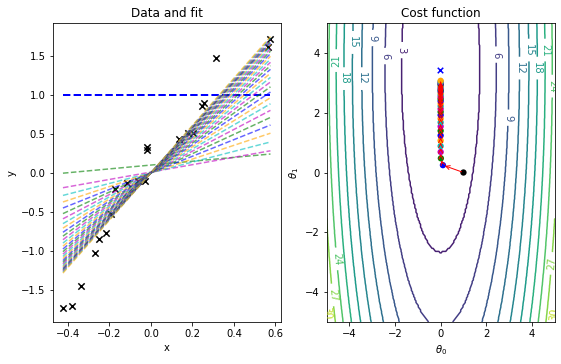

In [30]:
%matplotlib inline
singleFeatData = normalisedFeaturesHP[:,0][:,np.newaxis]
print(f'Features (range-normalised): {singleFeatData}\n')
trueValues     = y_data[:,np.newaxis]
trueValues     = (trueValues - np.mean(trueValues))/np.std(trueValues)
print(f'True values (range-normalised): {trueValues}\n')
stepsToTake    = 30
alpha          = 0.9
startThetas    = np.array([[1],[0]])


#Performing gradient descent
thetasDuringDescent       = [startThetas.copy()]
JsGradientDescent         = [linAlgMSE(singleFeatData, trueValues, np.ravel(thetasDuringDescent[-1].T))]
for step in range(0, stepsToTake):
    currentThetas = thetasDuringDescent[-1]
    newThetas     = linAlgGradientDescent(singleFeatData, trueValues, currentThetas, alpha)
    newJ          = linAlgMSE(singleFeatData, trueValues, newThetas)
    
    thetasDuringDescent.append(newThetas)
    JsGradientDescent.append(newJ)


##Plotting shenanigans##

#set up 2 plots
figGradDescent, axGradDescent = plt.subplots(nrows = 1, ncols = 2, figsize=(9,5.5))
#figGradDescent.tight_layout()
#colors for plotting gradient descent steps
colors = ['b', 'g', 'm', 'c', 'orange']

#scatterplot without normalised x values
axGradDescent[0].scatter(singleFeatData, trueValues, marker='x', s=40, color='k')
axGradDescent[0].set_ylabel("y")
axGradDescent[0].set_xlabel("x")

#calculate cost values for many different theta0, theta1 combinations
theta0Vals =  np.linspace(-5, 5, 200)
theta1Vals =  np.linspace(-5, 5, 200)
X, Y = np.meshgrid(theta0Vals, theta1Vals)
JVals = np.zeros(np.shape(X))
for i in range(0,len(theta0Vals)):
    for j in range(0,len(theta1Vals)):
        JVals[i,j] = linAlgMSE(singleFeatData, trueValues, np.array([X[i,j], Y[i,j]]))

#we can reuse the contour plot values we calculated before
contours = axGradDescent[1].contour(X, Y, np.round(JVals,1),
                         levels = 10)
axGradDescent[1].clabel(contours)
axGradDescent[1].set_xlabel(r"$\theta_0$")
axGradDescent[1].set_ylabel(r"$\theta_1$")
minimum = axGradDescent[1].scatter(X[JVals == np.min(JVals)], Y[JVals == np.min(JVals)],
                      color = "blue", label = "minimum", marker = "x",
                      s = 30)

#make the plot of gradient descent steps:

#if stepsToTake > colors, repeat the colors
colors = colors * int(np.ceil(stepsToTake/len(colors)))

#plot initial regression line
axGradDescent[0].plot(singleFeatData, linAlgRegHypothesis(singleFeatData, startThetas),
           color=colors[0], lw=2, linestyle = "dashed",
                        label=r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format(startThetas[0,0], startThetas[1,0])) 

#plot regression lines for each update
for j in range(1,stepsToTake):
    axGradDescent[1].annotate('', xy=np.ravel(thetasDuringDescent[j]), xytext=np.ravel(thetasDuringDescent[j-1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    axGradDescent[0].plot(singleFeatData, linAlgRegHypothesis(singleFeatData, thetasDuringDescent[j]),
               color=colors[j], lw=1.5, alpha = 0.6, linestyle = "dashed",
               label=list(map(r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format,*thetasDuringDescent[j])))

    
#add points in contour plot for different updated thetas
pointColors = colors.copy()
pointColors.insert(0, "black")
axGradDescent[1].scatter(*zip(*thetasDuringDescent), c=pointColors[0:len(thetasDuringDescent)], s=40, lw=0)

# Labels, titles and a legend.
axGradDescent[1].set_xlabel(r'$\theta_0$')
axGradDescent[1].set_ylabel(r'$\theta_1$')
axGradDescent[1].set_title('Cost function')

axGradDescent[0].set_title('Data and fit')
axbox = axGradDescent[0].get_position()
# Position the legend by hand so that it doesn't cover up any of the lines.
#if not stepsToTake > 10:
#    axGradDescent[0].legend(fontsize='small')

figGradDescent.show()


## What I want you to remember here
* You need to understand the logic behind k-fold cross-validation and why we do it: by subdividing our data into training folds and test folds, we have a number of estimates for how well our classifier will perform on unseen data. In other words: how well it will _generalise_. You don't, in the end, _use_ any of the classifiers you train during cross-validation: your final classifier would be trained on all your training data, and then published or shared with people. This means that your cross-validation estimates are even slightly pessimistic: more training data usually increases performance, and with cross-validation you always train on slightly less data than you have!
* How matrix-vector and matrix-matrix multiplication works, i.e. how to do it and how to code it with numpy. You should be able to perform some simple linear algebra multiplications by hand.
* How we use these types of multiplication to streamline and (especially for large datasets) speed up our implementations of ML algorithms, and specifically how you can implement linear regression and gradient descent using it. (Note: I don't expect you to know the exact implementations by heart, but I do want you to know the gist of the multiplications you're doing).
* That with these humble beginnings, you can already implement (a facsimile of) a GWAS procedure: relating a continuous variable to the nr. of alternative alleles you have at certain SNP locations (this you can try your hand at in the optional part below, or you just believe me). Pretty neat!

## The end

Congratulations, you've mastered linear regression using gradient descent and linear algebra.

## Survey
Did you like this practical? Did you hate it with a burning passion? Fill out [this survey](https://docs.google.com/forms/d/e/1FAIpQLSeJXmTlxMXUyCAndmuWVG4FhdFzNm4DEsy1nwswP7SAhOQwoA/viewform?usp=sf_link) and let us know (yes I became an us just now)!

## Start of the optional part

An earlier course installment made it clear that I was _ever so slightly_ too optimistic about what is achievable in one day while you are being hit with an onslaught of Numpy programming,partial derivatives and linear algebra left and right. So here are optional materials. This means you don't have to do them. Just in case you missed it: you can skip the below optional materials. 

However, what you _cannot_ skip is filling out the survey on what you thought of this practical. It's right up there ^

# OPTIONAL: Making a function that splits your training data into k folds for cross-validation

Now it's up to you to make a function `makeCrossValData(x, y, k=10)` that can take our data and create k folds from it for cross-validation.

So, what we want it to use as input and give as output: 
* It takes in an array with features and with labels.
* It should return four things total:
1. It should return two lists of length k. One list (trainSet) contains the row indices for the training data for a certain fold, the other (testSet) contains the row indices of the test data for a certain fold. This means that these lists are lists of lists: `trainSet[0]` should return something like `[3, 9, 14, 15, 20, 34]`, which are all the indices of the training samples to train on for the first cross-validation fold.
2. It should return the shuffled x and y arrays. <br> <br>
So, in sum, the return statement should look like `return shuffled_features, shuffled_labels, train_indices, test_indices`, where train_indices and test_indices are lists of length k.

What we want it to do:
* It first shuffles the data. You want to shuffle both the features and the labels/true values in the same way. You can use `np.random.permutation()` for this.
* It then makes k splits of the data. Note: you probably can't split the data exactly equally. Hence, use something like `int(np.floor(m/k))` , where m = # of samples, to determine the size of the equal splits you can make. And/Or use the modulo operator (`%`) to see the remainder after division by k (i.e. `9 % 4` = 1, because 2\*4 = 8, and then 1 is left).
* Make sure to identify the samples that remain because they can't be divided equally among the folds, and assign them to random folds.

Hints:
* This is somewhat difficult, requiring a bit of looping and checking to make sure that you first make proper-sized folds, then adding the remaining samples to random folds, and then outputting a correct list.
* If you need it: `[item for sublist in listWithSublists for item in sublist]` will take a list that looks like this: `[[25, 12, 3], [18, 33, 21], [1, 13, 5]]` and turn it into `[25, 12, 3, 18, 33, 21, 1, 13, 5]`. This is called a [list comprehension](https://www.datacamp.com/community/tutorials/python-list-comprehension) and is very powerful (but can also be somewhat unclear, and remember that one of the main purposes of code should be to be intelligible to humans that have to read and/or maintain it!).

In [6]:

#answer
def makeCrossValData(featureArray, y, k=10):
    '''function to make splits into training and validation sets.
    Outputs two lists of length k, where each element is the indices of samples to train on for that fold, 
    and the indices of samples to test on for that fold, respectively.'''
    m = len(featureArray)
    #shuffle data
    shuffled_indices = np.random.permutation(m)
    shuffled_features = featureArray[shuffled_indices,:] #assumes 2D array
    shuffled_labels   = y[shuffled_indices]
    #see how many equal-sized sets you can make
    dataPerSplit = int(np.floor(m/k))
    dataPartitions = []
    counter = 0

    for i in range(0,k):
        #make a list of all the samples for each fold
        dataPartitions.append(list(range(counter,counter+dataPerSplit)))
        counter += dataPerSplit

    samplesEquallySplit = k * dataPerSplit
    if not samplesEquallySplit == m:
        #after making equal splits there will be samples left, i.e. you cannot always make k exactly evenly sized subsets.
        #randomly assign left over samples to folds after
        toDivide = m-samplesEquallySplit
        for extraSampleIndex in range(counter, counter+toDivide):
            #only assign to lists of samples that have the current minimum amount of samples
            currentSubsetSizes = np.array([len(subset) for subset in dataPartitions])
            assignTo = np.random.choice(np.where(currentSubsetSizes == np.min(currentSubsetSizes))[0])
            dataPartitions[assignTo].append(extraSampleIndex)
    
    #Now make the final cross-validation set: make k sets, each set has (k-1)/k folds to train on, and 1 fold to test on.
    testSet = []
    trainSet = []
    for validationSetIndex in range(0,k):
        #put 1 fold in the test set
        testSet.append(dataPartitions[validationSetIndex])
        #put all other folds in the train set
        trainSet.append(dataPartitions.copy())
        trainSet[validationSetIndex].pop(validationSetIndex)
        #this line makes sure all training set indices are in one big list, rather than k-1 small lists. 
        trainSet[validationSetIndex] = [item for sublist in trainSet[validationSetIndex] for item in sublist]
    
    return shuffled_features, shuffled_labels, trainSet, testSet
   

## OPTIONAL: moving on to a GWAS(-like) analysis

Hopefully, it's a success! If not, be sure to check the shape of your arrays with `.shape` and `.ndim`, and try to figure out what inputs are going awry. <br> <br> <br> Now let's move on to some (very limited) GWAS analysis, based on data from [here](https://github.com/MareesAT/GWA_tutorial/). Below, we load in some example data and explore it. Before this can be done, do the following:

* Open an Anaconda prompt, activate the environment you use for the course (if using), and type `conda install -c conda-forge pandas-plink`
* You should have done this already in the pre-course setup but it's understandable if you missed it!

In [13]:
from pandas_plink import read_plink1_bin
euroGWASData = read_plink1_bin("HapMap_3_r3_1.bed", "HapMap_3_r3_1.bim", "HapMap_3_r3_1.fam", verbose=True)
print(euroGWASData)
print(euroGWASData.sel(sample = "NA06989"))
print(euroGWASData.sel(sample = "NA06989").values)

Mapping files: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.95s/it]


<xarray.DataArray 'genotype' (sample: 165, variant: 1457897)>
dask.array<transpose, shape=(165, 1457897), dtype=float32, chunksize=(165, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'NA06989' 'NA11891' ... 'NA10854' 'NA12865'
  * variant  (variant) <U14 'variant0' 'variant1' ... 'variant1457896'
    fid      (sample) object '1328' '1377' '1349' ... '1375' '1349' '1459'
    iid      (sample) object 'NA06989' 'NA11891' ... 'NA10854' 'NA12865'
    father   (sample) object '0' '0' '0' '0' ... '0' '0' 'NA11839' 'NA12874'
    mother   (sample) object '0' '0' '0' '0' ... '0' '0' 'NA11840' 'NA12875'
    gender   (sample) object '2' '1' '1' '2' '1' '2' ... '2' '1' '1' '1' '2' '2'
    trait    (sample) object '2' '2' '1' '2' '-9' ... '-9' '2' '1' '-9' '-9'
    chrom    (variant) object '1' '1' '1' '1' '1' ... '25' '25' '25' '25' '25'
    snp      (variant) object 'rs2185539' 'rs11510103' ... 'rs1973881'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0

## Questions about the GWAS dataset
The print-out of this data is rather complicated. That's because it is a read-in of binary datafiles in PLINK format, a command-line programme that is often used for GWAS analysis. The data is saved in an xarray, which is a specialised datatype that we won't go into here. Note that the rows have samples, and the columns contain features (here: 0, 1 or 2 for a certain SNP). Do the following:

* Go [here](https://pandas-plink.readthedocs.io/en/latest/usage.html) and read the entry under Genotype (ignore the Kinship matrix part). After that, read [this](https://pandas-plink.readthedocs.io/en/latest/api/pandas_plink.read_plink1_bin.html)

Answer these questions:

1. How many SNPs are in this data?
2. How many SNPs are on chromosome 11?
3. How many male genomes are in this dataset? (see [this](https://www.cog-genomics.org/plink/1.9/formats#fam))
4. How many genomes lack gender annotation?

In [14]:
#answer
#1. 1457897
print(len(euroGWASData.sel(sample = "NA06989").values))
#2. 72993
chromElevenData = euroGWASData.where(euroGWASData.chrom == "11", drop = True)
print(chromElevenData.shape[1])
#3. 80/165
maleNumber = euroGWASData.where(euroGWASData.gender == "1", drop = True).shape
print("Number of males: " + str(maleNumber[0]))
#4. None
genderLess = euroGWASData.where(euroGWASData.gender == "0", drop = True).shape
print("No gender known: " + str(genderLess[0]))


1457897
72993
Number of males: 80
No gender known: 0


# SNP analysis on chromosome eleven subset.
Let's continue with only SNPs on chromosome eleven, and 'only' 200 SNPs there. That's still plenty of data. As you've been told, a GWAS simply trains a linear model on the #of alles you have for a certain SNP: if A is normal at a location and you have 2* A, you have 0. If you have a T in 1 copy of that gene, you have 1. If you are homozygously different from A (2 Ts), you have a 2. In contrast to more complex algorithms, SNPs are supposed to have additive effects: we simply tally the effect of one SNP on having the outcome measure with all others, and the total would be the expected effect of your genetic make-up on some outcome like BMI. Within SNPs, too, we generally assume an additive model: that having 2 alternative alleles at a SNP location has twice the effect of having 1. In reality, of course, there can be epistasis, or one allele could do nothing but having 2 mutations has a very large effect (All this is simplifying the field of GWAS, of course, there's a _lot_ of nuance we're leaving out for the purpose of brevity).

The cell immediately below makes sure that there is a simulated quantitative outcome measure (BMI), and that a few SNPs on chromosome eleven influence this trait. You can just run it and move on to the next cell to run linear regressions on those SNPs using your own functions. Below are the well-known Manhattan plots of GWAS, which require p-values for the associations in the linear regressions. We haven't talked about how to get those.
![Manhattan plots](ManhattanPlot.jpg)

It's outside of the scope here to go all-in on explaining this, but you can calculate the standard error of a regression slope. The formula for it is: $$\sqrt{\frac{1}{m-2} \cdot \frac{\sum_{i=1}^m(y_i-\hat{y}_i)^2}{\sum_{i=1}^m(x_i - x_{mean})^2}}$$
Here, $m$ is the number of samples, the top calculates sum of square errors, and the bottom calculates the sum of squares of the features (since we mean-center our features the mean should be 0). The upshot is that this formula calculates how much, on average, the real values differ from the predicted values. For further info, see [this StatQuest video](https://www.youtube.com/watch?v=XNgt7F6FqDU) and [this web page](https://www.statology.org/standard-error-regression/).

With this formula in hand, we can calculate a t-statistic, and with a t-statistic, we can perform significance testing, i.e. we can say what the chance is that a result this strong or stronger could have occured just by chance (Although of course significance testing and/or hypothesis testing has received a lot of flak, and rightly so, see: [1](https://arbital.com/p/likelihoods_not_pvalues/?l=4xx), [2](https://arbital.com/p/likelihoods_not_pvalues/), and [3](https://sci-hub.se/https://doi.org/10.17763/haer.48.3.t490261645281841). For a zealous account, see [4](https://sci-hub.se/https://doi.org/10.5153%2Fsro.3857)). Still, that discussion is not the focus here. Calculating the t-statistic is extremely simple: it's just $t = \frac{\theta_1}{SE(\theta_1)}$

Intuitively, you can understand that the right plot below has lower standard error, so we are more sure of our estimated slope of the regression line than we are on the left, where it feels like the slope might be very different if we had more samples. We can codify this with a p-value, as is done in GWAS (although see the above _strong condemnations_ of p-values).
![plotSERegression](ExampleSERegression.PNG)

I supply functions to calculate the p-value from the linear regressions you fit, then we'll look at the 20 lowest p-values.

That was a lot of text. Summary:
* Run the cell below. It results in data that has 200 SNP positions on chromosome 11, of which 20 have an effect on BMI.
* Move on to the cell below that to get to work doing the linear regressions you need to do
* Use the supplied functions to calculate the p-value for the slope of each regression.

In [15]:
downsizedData = euroGWASData.where(euroGWASData.chrom == "11", drop = True)
downsizedData = downsizedData[:, rand.sample(range(0, downsizedData.shape[1]), 200)]
#remove columns that have all 0, 1 or 2 --> can't infer anything there
columnsWithoutVariation = np.all(downsizedData.values == downsizedData.values[0,:], axis = 0)
downsizedData = downsizedData[:, np.invert(columnsWithoutVariation)]


#sample some SNPs to assign a signal
SNPsForSignal = np.array(rand.sample(range(0, downsizedData.shape[1]), 20))

#add normally distributed BMI value with mean that is somewhat healthy 
newArray = np.zeros(len(downsizedData.trait))
downsizedDataNew = downsizedData.drop_vars("trait")
newArray = np.random.default_rng().normal(22.5, 1, len(newArray))
downsizedDataNew["BMI"] = ("sample", newArray)


#now, give certain SNPs a protective effect for BMI (help in being leaner) and a few the effect of predisposing to high BMI
#assume additivity within the SNP, which is to say: one protective allele has half the protective effect of 2.
protectiveSNPs = np.array(rand.sample(list(SNPsForSignal), 5))
diseaseSNPs    = np.array([i for i in SNPsForSignal if i not in protectiveSNPs])

protectiveEffect = 3
for protSNPCoord in protectiveSNPs:
    twoAlleles  = np.where(downsizedDataNew[:, protSNPCoord].values == 2.)
    oneAllele   = np.where(downsizedDataNew[:, protSNPCoord].values == 1.)
    noMuts      = np.where(downsizedDataNew[:, protSNPCoord].values == 0.)
    newArray[twoAlleles] -= np.random.default_rng().normal(protectiveEffect, 0.1, len(twoAlleles))
    newArray[oneAllele]  -= np.random.default_rng().normal(protectiveEffect/2, 0.1, len(oneAllele))

obesityEffect = 3.87
for disSNPCoord in diseaseSNPs:
    twoAlleles  = np.where(downsizedDataNew[:, disSNPCoord].values == 2.)
    oneAllele   = np.where(downsizedDataNew[:, disSNPCoord].values == 1.)
    noMuts      = np.where(downsizedDataNew[:, disSNPCoord].values == 0.)
    newArray[twoAlleles] += np.random.default_rng().normal(obesityEffect, 0.1, len(twoAlleles))
    newArray[oneAllele]  += np.random.default_rng().normal(obesityEffect/2, 0.1, len(oneAllele))


downsizedData["BMI"] = ("sample", newArray)    


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Doing your analysis
Okay, the data is all set up. There is just one thing: there are missing data in this GWAS dataset: SNPs that were not measured for certain people. For now, we'll just replace these NaNs with 0, assuming they are the most common genotype. In fact, there's two things: the second one is that there are SNPs where every person in the dataset has either 0, 1, or 2: we can't say anything there. I've prefiltered those columns out for you in the code cell above. Now to run the linear regressions as used in GWAS:
* Loop over the columns of the `downsizedData`. Each column contains data for a single SNP. To get at this data, use `downsizedData[:, columnNr].values`
* This SNP data is your feature. Run linear regression on this feature, using the BMI as the outcome. Don't forget to add the intercept feature which is just an array of ones (or alternatively, this might be incorporated into your linAlgGradientDescent function already).
* To run linear regression:
    * Make sure you normalise the feature and the BMI.
    * Initialise thetas (done for you).
    * Run gradient descent for a number of steps (nSteps = 20 below)
    * Save the resulting theta values in a list or array, so that you get, per SNP in the data, the two thetas.

After this is done, we'll worry about calculating the p-values. 

In [17]:
#set-up. Set mean BMI as start value for intercept.
startThetas = np.array([[np.mean(newArray)], [0]])
nSteps      = 20
outcome     = downsizedData["BMI"].values
#Normalise the outcome measure!

alpha       = 0.3 
listThetasForEachSNP = []




#up to you: use gradient descent to find the thetas, save these thetas in a list after all nSteps are done.
#don't forget to normalise BMI and the features!
for SNPIndex in range(0, downsizedData.shape[1]):
    #replace np.nan with 0
    values = downsizedData[:, SNPIndex].values
    values[np.isnan(values)] = 0
    
    for step in range(0, nSteps):
        break
    break
        
        
#Answer
outcomeNorm, outcomeMean, outcomeSD = createNormalisedFeatures(outcome, mode = "SD")

for SNPIndex in range(0, downsizedData.shape[1]):
    features = downsizedData[:, SNPIndex].values
    features[np.isnan(features)] = 0
    featuresNorm, mean, SD = createNormalisedFeatures(features, mode= "SD")
    currentThetas = startThetas
    for step in range(0, nSteps):
        newThetas     = linAlgGradientDescent(featuresNorm, outcomeNorm, currentThetas, alpha)
        currentThetas = newThetas
    listThetasForEachSNP.append(currentThetas)




## Functions to get the p-values for each regression

Run the cell below to get the function you need. Note: you separately fit a regression for each SNP, and this function works on the theta parameters (here, only $\theta_1$) for each of these regressions.

In [18]:
def calcPValuesRegSlope(X, y, thetas):
    """Skips calculation for the significance of the intercept (i.e. it being sig. different from 0,
    as it's the relation between BMI and the SNP we are interested in. Assumes theta as a vector (2D numpy array) of
    n_thetas by 1 (so 2 rows, 1 column for univariate linear regression)"""
    m = len(X)
    thetasToCalc = thetas[1:,:]
    preds = linAlgRegHypothesis(X, thetas)
    #print(preds)
    #print(y)
    if not y.ndim > 1:
        y = y[:, np.newaxis]
    #print(X)

    sumSquareErrorsPred = np.sum(np.square(np.array(preds) - y))
    stdErrors = []; tStats = []; pVals = []
    for index, theta in enumerate(thetasToCalc):
        #print(theta) ;print(index)
        sumSquaresFeature = np.sum(np.square(X - np.mean(X)))
        stdError = np.sqrt((1/(m-2)) * (sumSquareErrorsPred/sumSquaresFeature))
        tStat    = theta/stdError
        pVal     = scipy.stats.t.sf(abs(tStat), m-1)
        stdErrors.append(stdError); tStats.append(tStat); pVals.append(pVal)
    
    df = pd.DataFrame(np.vstack([stdErrors, tStats, pVals]))
    df.set_index(pd.Index(["standard errors", "t statistics", "p-values"]), inplace = True)
    return[pVals, df]
    

## Getting the p-values

The below code will get you p-values for every SNP. All you need to do is give it a list of thetas to work on. That list of thetas should have n_SNPs entries, and each entry is, in this case, a 2 by 1 2D array, containing $\theta_0$ and $\theta_1$ for the linear regression of BMI against # of alternative alleles for that SNP. Up to you to:

* **Replace listThetasForEachSNP in `enumerate(listThetasForEachSNP)` with your name for a list with the 2 thetas for each of the 200 linear regressions you trained**
* Inspect the p-values. How many are less than 0.05? How many would you expect?

In [19]:
pValsPerSNP = []
listDFs = []
outcomeNorm, outcomeMean, outcomeSD = createNormalisedFeatures(outcome, mode = "SD")
dataWithoutNA = downsizedData.values; dataWithoutNA[np.isnan(dataWithoutNA)] = 0
dataNorm, dataMeans, dataSDs        = createNormalisedFeatures(pd.DataFrame(dataWithoutNA), mode = "SD")
for SNPindex, thetas in enumerate(listThetasForEachSNP):
    pVal, dfInfo = calcPValuesRegSlope(np.array(dataNorm.iloc[:, SNPindex]), outcomeNorm, thetas)
    pValsPerSNP.append(pVal[0])
    listDFs.append(dfInfo)

pValuesPerSNPFinal = np.ravel(np.hstack(pValsPerSNP))
print(pValuesPerSNPFinal)

# answer
print("# of locations where p <= 0.05: " + str(len(np.where(pValuesPerSNPFinal <= 0.05)[0])))
# given a cut-off of 0.05, you'd expect 200* 1/20 (random chance) + 20 (signal I added) = 30. So there's quite a bit more.



[4.74687202e-01 2.77915945e-01 3.93910618e-01 9.99388729e-02
 5.17879435e-02 1.51719759e-03 4.85967273e-01 1.91069181e-01
 3.37095103e-01 1.99184676e-01 3.83498147e-01 1.37121010e-02
 4.17944368e-01 3.12374939e-01 1.41400172e-01 2.03951056e-01
 4.52928214e-01 2.49465269e-01 4.81069351e-01 2.91686529e-01
 4.72233347e-01 2.07609369e-01 3.26621258e-01 7.06043931e-03
 3.79440183e-01 4.72206357e-01 1.81691737e-01 3.95612312e-01
 1.23949761e-01 3.91341874e-01 2.80542523e-02 5.01437555e-02
 4.95722400e-01 3.58863087e-01 4.66280176e-01 1.10731093e-01
 3.29807559e-01 4.89357091e-01 3.79599925e-01 2.71684748e-02
 4.90156403e-01 7.16694724e-02 5.66218940e-02 6.32365480e-02
 4.64766241e-01 5.38102841e-03 7.22506241e-08 1.96354516e-01
 3.78825413e-01 2.56707620e-03 1.30601514e-01 1.16850179e-01
 1.82057103e-01 6.85848354e-02 2.28569197e-01 3.30485965e-02
 3.91540546e-01 3.91141416e-01 2.92763925e-01 3.49117274e-01
 1.72382174e-01 4.03231782e-01 1.71903957e-01 3.09700556e-02
 2.11623277e-01 3.059869

## Checking the regression values you obtained

Now, let's take the 20 lowest p-values values and see whether these correspond to the signal we put into the BMI values. Remember, I added signal to 20 SNPs so you would find it easily in this _very small_ practice dataset. Of course, in normal GWAS procedure they use very stringent genome-wide p-value thresholds, much lower than 0.05, or they do some other sort of multiple testing correction, and often the SNPs are validated later. For our simple purposes here, though, let's just take the 20 lowest p-values, i.e. the SNPs where the chance that this regression slope or a more extreme one was found by simple chance/noise is lowest.

In [20]:
lowestPValues = np.argsort(pValuesPerSNPFinal)[0:20]
# check whether this is the signal I put in
matches  = np.in1d(SNPsForSignal, lowestPValues)
nMatches = sum(matches)
print("SNPs with top 20 lowest p-values which are indeed of the 20 to which I added signal: " + str(nMatches))

SNPs with top 20 lowest p-values which are indeed of the 20 to which I added signal: 13


## Result

If things are similar on your side, you'll get that about half (I had 12/20) were indeed the SNPs where I put signal in. This shows that correction for spurious hits is a big deal in GWAS: even though I _added_ a lot of over-the-top signal, we still didn't retrieve all of them. Of course, our sample size is very low, which makes spurious results easier. Below we plot the regressions you fitted for the SNPs that had actual business being found as significant.

## Plotting the linear regressions for SNPs with large effect sizes

The below plots the linear regression plots for those SNPs that have actual signal. **Again, replace listThetasForEachSNP with the correct name for your list of theta parameters for each linear regression**.


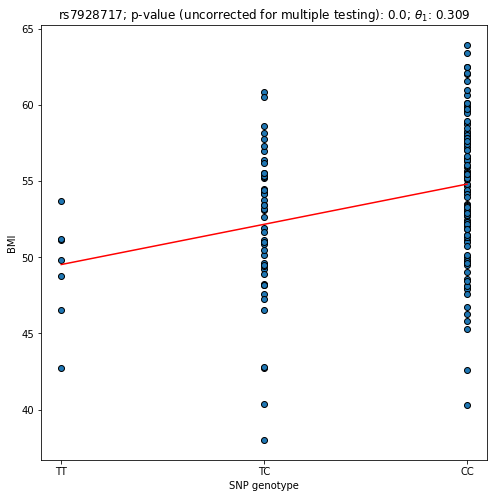

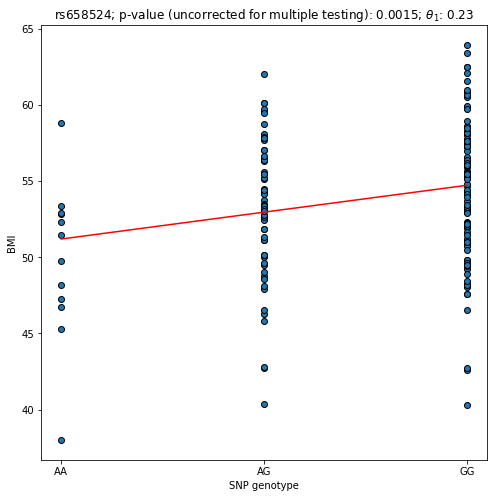

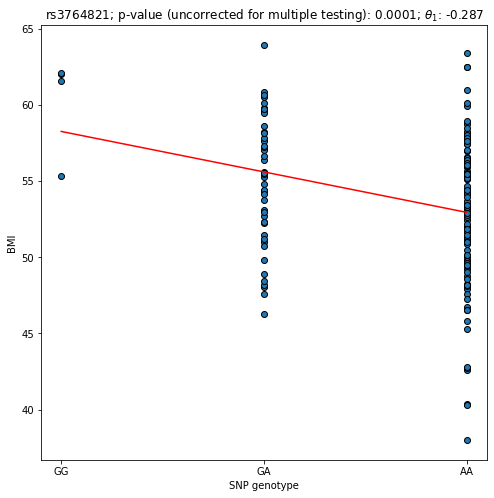

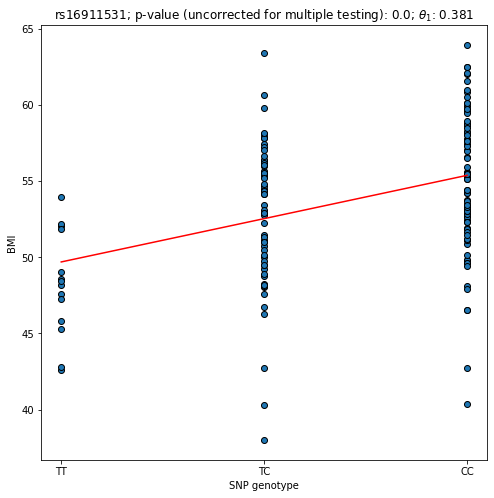

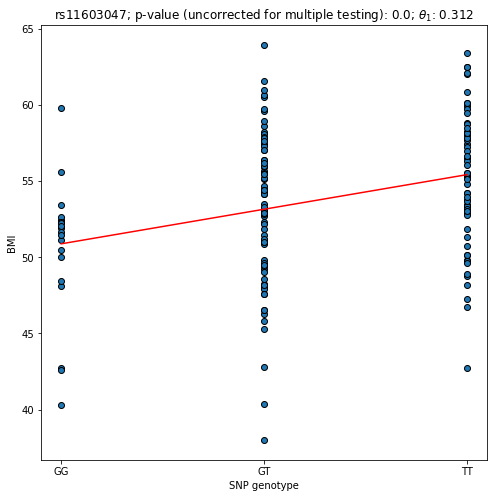

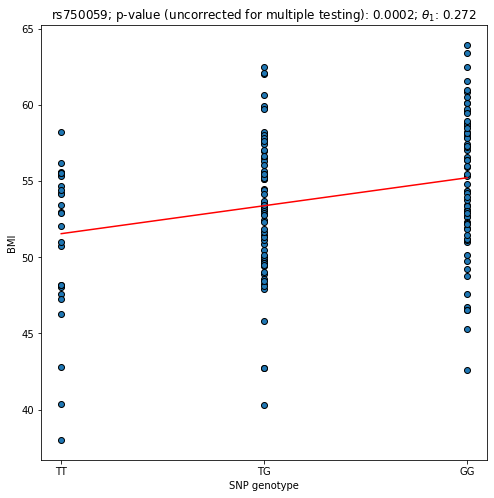

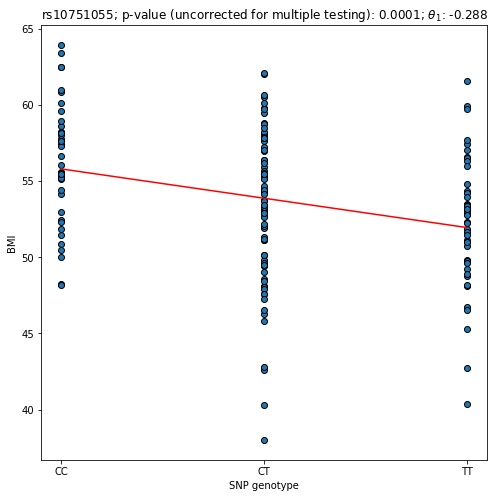

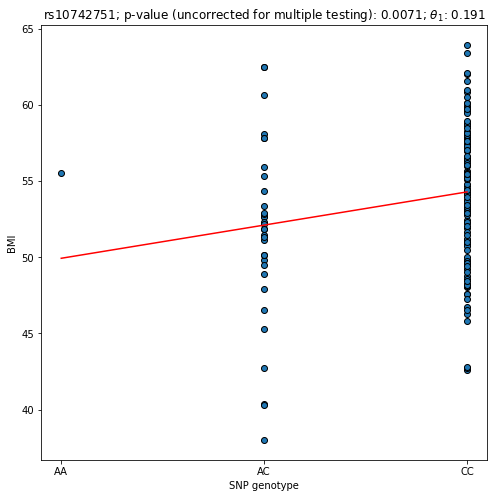

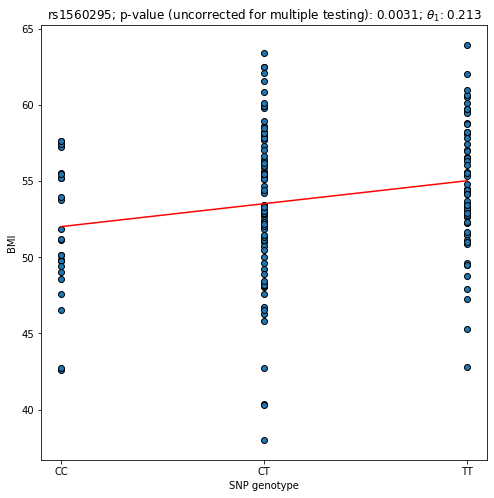

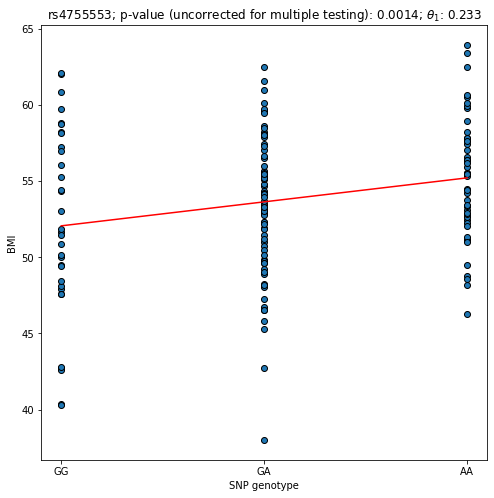

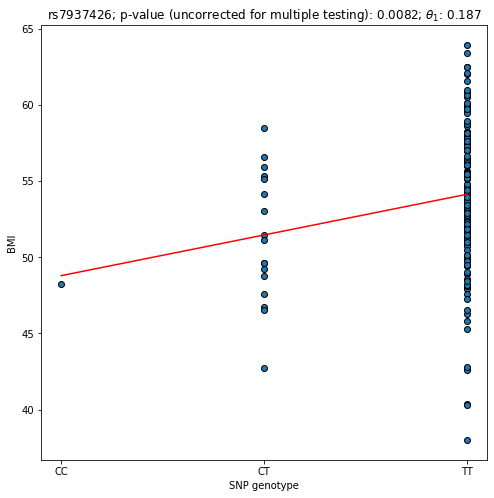

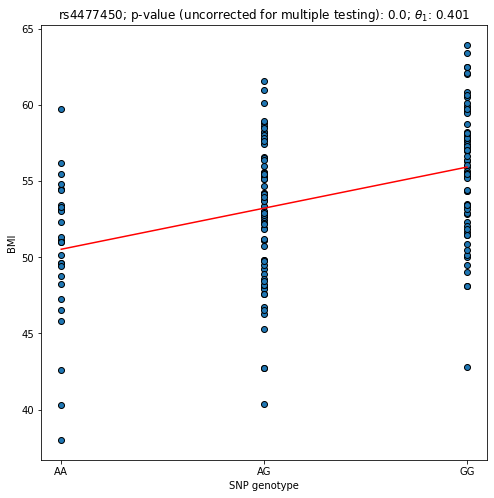

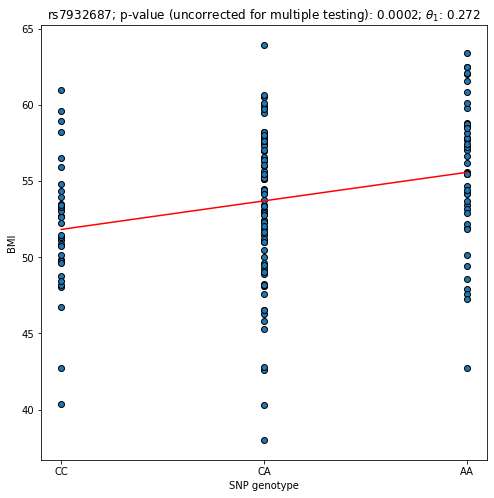

In [21]:
import warnings
%matplotlib inline 

SNPsWithLowPValues = SNPsForSignal[matches]

outcomeNorm, outcomeMean, outcomeSD = createNormalisedFeatures(outcome, mode = "SD")

neededData = downsizedData[:, SNPsWithLowPValues]

for SNPindex, SNPlocation in enumerate(SNPsWithLowPValues):
    thetasHere = listThetasForEachSNP[SNPlocation]
    #twentyLargestThetaOnes.iloc[0:2, np.where(twentyLargestThetaOnes.columns == SNPlocation)[0][0]]
    #maybe return to normal coordinates
    features = neededData.values[:, SNPindex]
    features[np.isnan(features)] = 0
    featuresNorm, mean, SD = createNormalisedFeatures(features, mode= "SD")
    SNPsPresentInData = np.in1d(np.array([0., 1.,2.]), features)
    #skip SNPs where not all 3 genotypes are present, complicates plotting considerably
    if not np.all(SNPsPresentInData):
        continue
    normalAllele = neededData["a0"].values[SNPindex]
    alternativeAllele = neededData["a1"].values[SNPindex]
    xLabels = [normalAllele*2, normalAllele+alternativeAllele, alternativeAllele*2]
    xLabels = np.array(xLabels)[np.where(np.in1d(np.array([0., 1.,2.]), features))]
    SNPName = neededData["snp"].values[SNPindex]
    #only predict once for each possible feature value
    uniqueAlleleNr = np.sort(np.unique(featuresNorm))
    predictions = linAlgRegHypothesis(uniqueAlleleNr, thetasHere)
    #print(predictions)
    #print(predictions * SD + mean)
    fig, ax = plt.subplots(figsize = (8,8))
    ax.scatter(featuresNorm, outcomeNorm *outcomeSD + outcomeMean, edgecolors = "black")
    ax.set_xticks(np.unique(featuresNorm))
    ax.set_xlabel("SNP genotype")
    ax.set_xticklabels(xLabels.tolist())
    ax.set_ylabel ("BMI")
    ax.set_title(SNPName + "; p-value (uncorrected for multiple testing): " + str(np.round(pValuesPerSNPFinal[SNPlocation], 4)) + "; $\\theta_1$: " + str(np.round(np.ravel(thetasHere)[1], 3)))
    ax.plot(uniqueAlleleNr, predictions * outcomeSD + outcomeMean, color = "red")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig.show()


## You are here. Did you bring your towel?

Darn, what a rush. I hadn't expected anyone after all this optionality. Well, congrats. If you're reading this you're either a) capable of scrolling all the way down in a Jupyter Notebook (no easy feat for sure), or b) went ahead and made your own cross-validation function and did a faux-GWAS analysis. Wow! 

I'd like to stress once more that the 'GWAS' we've done here is a parody of the real thing. There's familial relations to take into account (you share many SNPs with parents and grandparent), sex assignment to check, missing data to impute or otherwise correct for, etc. Nevertheless, the principle of running a linear regression for each SNP is the same. At the end of the week, we'll be able to correct a GWAS for population covariance in SNPs which will already bring us closer to the real deal.